# Jet power estimation of MAXI J1348-630

In this document we go through the different assumptions made to calculate the jet power output with the calorimetric method, accounting for uncertainty and propagating it throughout our results.

## Volume estimate:

For the volume we take a spheroid centered on the source with a radius that encompasses the whole emission. We have measured the angular size of the radius ($h$) and performed a volume computation in cm$^3$ assuming that the physical scale of the radius in good paraxial approximation is $R=h\cdot D$ where D is the distance estimate to the source:

$V= \frac{4}{3} \pi R^3$

We have taken both distance estimations found in the literature up to date with their respective uncertainties propagated into the final result.

In [3]:
import numpy as np
from astropy.io import fits
import astropy.units as u

#Total area of emission

r_app = 44.0*(1./3600.)*(np.pi/180.0) #rad
dr_app  = 1.0*(1./3600.)*(np.pi/180.0) #rad



#Chauhan et al 2021
D_1=2200.0 * 3.086e18 #pc converted to cm
dD_1_plus=500 * 3.086e18 #pc converted to cm
dD_1_minus=600 * 3.086e18 #pc converted to cm

#Lamer et al 2021
D_2= 3390.0 * 3.086e18 #pc converted to cm
dD_2 = 340.0 * 3.086e18 #pc converted to cm


tot_V_close = 4./3. * np.pi* (r_app * D_1)**3 #cm^3
tot_V_far = 4./3. * np.pi* (r_app * D_2)**3 #cm^3


err_tot_V_close_plus = np.sqrt((4.*np.pi*r_app**2 *D_1**3 *dr_app)**2 + (4.*np.pi*r_app**3 * D_1**2 * dD_1_plus)**2)
err_tot_V_close_minus= np.sqrt((4.*np.pi*r_app**2 *D_1**3 *dr_app)**2 + (4.*np.pi*r_app**3 * D_1**2 * dD_1_minus)**2)
err_tot_V_far = np.sqrt((4.*np.pi*r_app**2 *D_2**3 *dr_app)**2 + (4.*np.pi*r_app**3 * D_2**2 * dD_2)**2)


print(f"Total Volume: {tot_V_close:.2e} cm^3 (+{err_tot_V_close_plus:.2e}, -{err_tot_V_close_minus:.2e}) cm^3; Chauhan")
print(f"Total Volume: {tot_V_far:.2e} cm^3 (+-{err_tot_V_far:.2e}) cm^3; Lamer")

Total Volume: 1.27e+55 cm^3 (+8.72e+54, -1.04e+55) cm^3; Chauhan
Total Volume: 4.66e+55 cm^3 (+-1.44e+55) cm^3; Lamer


## Cloud mass estimate:

For cloud mass, we take the assumption that our column densities for $^{13}CO$ are accurate and perform a linear transformation to $H_2$ column densities with values found in the literature. We notice that after analysing our $H_2$ maps produced with both relations used, we find the column density to be in agreement with those upper limits set on [Bhowmick et al., 2022](https://www.mdpi.com/2075-4434/10/5/95) with X-ray observations of the second ever observed outburst of the source.

We use the values found in [Wilson & Rood, 1994](https://adsabs.harvard.edu/full/1994ARA%26A..32..191W) and [Kohno & Sofue, 2023](https://www.ioa.s.u-tokyo.ac.jp/~sofue/news/2020_mn_Xco12co13_fugin.pdf).

A $\mu$ factor accounts for the presence of hydrogen and other heavy elements in molecular clouds. A typical value for molecular clouds in the galactic plane is $\mu =2.7$ .

We assume the physical size of our pixel to be the angular size ($\theta_{pix}$ times the distance $D$ (in cm) in good paraxial approximation. 

Then, we sum the column density over all particles in the physical scale of a pixel ($N_{pix}$) and multiply by the mass of hydrogen (in g). We present the values in $M_\odot$ for convenience. Summatory affects the whole image:

$M=\sum_{im} N_{pix} \cdot \theta_{pix}^2 \cdot D^2 \cdot m_H \cdot \mu$

In [5]:
#We will now compute the mass of the cloud using different literature values. 
#In this case we take the whole cloud observed at a given distance/velocity chunk

import numpy as np
from astropy.io import fits
import astropy.units as u

# Constants
m_H = 1.67e-24  # g
#m_H=1.0
mu = 2.7
Msun = 1.989e33  # g

# Inputs
theta_pix = (1.9444444e-04)*(np.pi/180.0) # deg to rad, replace with your value

#From Lamer et al., 2021
D_2 = 3390 * 3.086e18  # cm (convert from pc if needed)
D_err_2_plus = 340 * 3.086e18  # Upper error in cm
D_err_2_minus = 340 * 3.086e18  # Lower error in cm

#From Chauhan et al., 2021
D = 2200 * 3.086e18 #cm
D_err_plus = 500 * 3.086e18
D_err_minus = 600 * 3.086e18

# Compute pixel area in cm^2
A_pix = (theta_pix)**2 * D**2  # cm^2
A_pix_2 = (theta_pix)**2 * D_2**2  # cm^2


# Load column density map (cm^-2)
hdu = fits.open("CO13_comb_column.fits")[0]
N_tot = hdu.data  # cm^-2
header = hdu.header

#First we transform the 13CO map to H_2 using a linear relationship.
N_tot_1 = N_tot/1.6e-5 #cm^-2 Wilson & Rood 1994
N_tot_2 = N_tot * 5e5 #cm^-2 Kohno & Sofue 2023
#N_tot_3 = 1.4*N_tot_2 #cm^-2 Kohno & Sofue 2023 accounting for He and heavy elements 
C =5e5 #cm^-2 Kohno & Sofue
C_err = 2.5e5 #cm^-2 error for the constant in Kohno & Sofue
# Compute total mass per pixel (g)
M_pix_close_1 = N_tot_1 * A_pix * mu * m_H
M_pix_close_2 = N_tot_2 * A_pix * mu * m_H
#M_pix_close_3 = N_tot_3 * A_pix * mu * m_H
M_pix_far_1 = N_tot_1 * A_pix_2 * mu * m_H
M_pix_far_2 = N_tot_2 * A_pix_2 * mu * m_H
#M_pix_far_3 = N_tot_3 * A_pix_2 * mu * m_H

# Integrate over all pixels
M_tot_close_1 = np.nansum(M_pix_close_1)/Msun  # M_\odot
M_tot_close_2 = np.nansum(M_pix_close_2)/Msun  # M_\odot
#M_tot_close_3 = np.nansum(M_pix_close_3)/Msun  # M_\odot
M_tot_far_1 = np.nansum(M_pix_far_1)/Msun  # M_\odot
M_tot_far_2 = np.nansum(M_pix_far_2)/Msun  # M_\odot
#M_tot_far_3 = np.nansum(M_pix_far_3)/Msun  # M_\odot

# Propagate asymmetric errors
M_err_plus_close_1 = 2 * (D_err_plus / D) * M_tot_close_1
M_err_minus_close_1 = 2 * (D_err_minus / D) * M_tot_close_1
M_err_plus_close_2 = np.sqrt((C_err/C)**2 +(2 * (D_err_plus / D))**2) * M_tot_close_2
M_err_minus_close_2 =np.sqrt((C_err/C)**2 +(2 * (D_err_minus / D))**2) * M_tot_close_2
#M_err_plus_close_3 =np.sqrt((C_err/C)**2 +(2 * (D_err_plus / D))**2) * M_tot_close_3
#M_err_minus_close_3 = np.sqrt((C_err/C)**2 +(2 * (D_err_minus / D))**2) * M_tot_close_3
M_err_plus_far_1 = 2 * (D_err_2_plus / D_2) * M_tot_far_1
M_err_minus_far_1 = 2 * (D_err_2_minus / D_2) * M_tot_far_1
M_err_plus_far_2 = np.sqrt((C_err/C)**2 +(2 * (D_err_2_plus / D_2))**2) * M_tot_far_2
M_err_minus_far_2 = np.sqrt((C_err/C)**2 +(2 * (D_err_2_minus / D_2))**2) * M_tot_far_2
#M_err_plus_far_3 = np.sqrt((C_err/C)**2 +(2 * (D_err_2_plus / D_2))**2) * M_tot_far_3
#M_err_minus_far_3 = np.sqrt((C_err/C)**2 +(2 * (D_err_2_minus / D_2))**2) * M_tot_far_3

# Print results
print(f"Total mass: {M_tot_close_1:.2e} Msun (+{M_err_plus_close_1:.2e}, -{M_err_minus_close_1:.2e}) Msun; Wilson Rood, Chauhan")
print(f"Total mass: {M_tot_close_2:.2e} Msun (+{M_err_plus_close_2:.2e}, -{M_err_minus_close_2:.2e}) Msun; Kohno Sofue, Chauhan")
#print(f"Total mass: {M_tot_close_3:.2e} Msun (+{M_err_plus_close_3:.2e}, -{M_err_minus_close_3:.2e}) Msun; Kohno Sofue He, Chauhan")
print(f"Total mass: {M_tot_far_1:.2e} Msun (+{M_err_plus_far_1:.2e}, -{M_err_minus_far_1:.2e}) Msun; Wilson Rood, Lamer")
print(f"Total mass: {M_tot_far_2:.2e} Msun (+{M_err_plus_far_2:.2e}, -{M_err_minus_far_2:.2e}) Msun; Kohno Sofue, Lamer")
#print(f"Total mass: {M_tot_far_3:.2e} Msun (+{M_err_plus_far_3:.2e}, -{M_err_minus_far_3:.2e}) Msun; Kohno Sofue He, Lamer")

Total mass: 5.42e+00 Msun (+2.47e+00, -2.96e+00) Msun; Wilson Rood, Chauhan
Total mass: 4.34e+01 Msun (+2.93e+01, -3.21e+01) Msun; Kohno Sofue, Chauhan
Total mass: 1.29e+01 Msun (+2.58e+00, -2.58e+00) Msun; Wilson Rood, Lamer
Total mass: 1.03e+02 Msun (+5.55e+01, -5.55e+01) Msun; Kohno Sofue, Lamer


## Density estimates:

We take our values of density by using our previously computed mass and volume values. Again, we account for all possible scenarios in both distance estimations.

We also notice that the measured mass is not filling the volume completely, so we take a filling factor $f$ which will have great effect on the final power estimate:

$$\rho_0=\frac{M}{f \cdot V}$$

Notice that $Q_j \propto f^{-1}$.

In [7]:
#Now we compute the average density of the region for the whole setup
#We need to account for all 6 mass setups computed:
f=0.1

rho_1_close = M_tot_close_1*Msun/(f*tot_V_close) #Wilson Rood; Chauhan
rho_2_close = M_tot_close_2*Msun/(f*tot_V_close) #Kohno Sofue no He; Chauhan
#rho_3_close = M_tot_close_3*Msun/(f*tot_V_close) #Kohno Sofue He; Chauhan

rho_1_far = M_tot_far_1*Msun/(f*tot_V_far) #Wilson Rood; Lamer
rho_2_far = M_tot_far_2*Msun/(f*tot_V_far) #Kohno Sofue no He; Lamer
#rho_3_far = M_tot_far_3*Msun/(f*tot_V_far) #Kohno Sofue He ; Lamer

drho_1_close_plus = np.sqrt((M_err_plus_close_1*Msun/tot_V_close)**2 + (M_tot_close_1*Msun*err_tot_V_close_plus/tot_V_close**2)**2)
drho_1_close_minus = np.sqrt((M_err_minus_close_1*Msun/tot_V_close)**2 + (M_tot_close_1*Msun*err_tot_V_close_minus/tot_V_close**2)**2)
drho_2_close_plus = np.sqrt((M_err_plus_close_2*Msun/tot_V_close)**2 + (M_tot_close_2*Msun*err_tot_V_close_plus/tot_V_close**2)**2)
drho_2_close_minus = np.sqrt((M_err_minus_close_2*Msun/tot_V_close)**2 + (M_tot_close_2*Msun*err_tot_V_close_minus/tot_V_close**2)**2)
#drho_3_close_plus = np.sqrt((M_err_plus_close_3*Msun/tot_V_close)**2 + (M_tot_close_3*Msun*err_tot_V_close_plus/tot_V_close**2)**2)
#drho_3_close_minus = np.sqrt((M_err_minus_close_3*Msun/tot_V_close)**2 + (M_tot_close_3*Msun*err_tot_V_close_minus/tot_V_close**2)**2)

drho_1_far_plus = np.sqrt((M_err_plus_far_1*Msun/tot_V_far)**2 + (M_tot_far_1*Msun*err_tot_V_far/tot_V_far**2)**2)
drho_1_far_minus = np.sqrt((M_err_minus_far_1*Msun/tot_V_far)**2 + (M_tot_far_1*Msun*err_tot_V_far/tot_V_far**2)**2)
drho_2_far_plus = np.sqrt((M_err_plus_far_2*Msun/tot_V_far)**2 + (M_tot_far_2*Msun*err_tot_V_far/tot_V_far**2)**2)
drho_2_far_minus = np.sqrt((M_err_minus_far_2*Msun/tot_V_far)**2 + (M_tot_far_2*Msun*err_tot_V_far/tot_V_far**2)**2)
#drho_3_far_plus = np.sqrt((M_err_plus_far_3*Msun/tot_V_far)**2 + (M_tot_far_3*Msun*err_tot_V_far/tot_V_far**2)**2)
#drho_3_far_minus = np.sqrt((M_err_minus_far_3*Msun/tot_V_far)**2 + (M_tot_far_3*Msun*err_tot_V_far/tot_V_far**2)**2)

print(f"Total density: {rho_1_close:.2e} g/cm^3 (+{drho_1_close_plus:.2e}, -{drho_1_close_minus:.2e}) g/cm^3; Wilson Rood, Chauhan")
print(f"Total density: {rho_2_close:.2e} g/cm^3 (+{drho_2_close_plus:.2e}, -{drho_2_close_minus:.2e}) g/cm^3; Kohno Sofue, Chauhan")
#print(f"Total density: {rho_3_close:.2e} g/cm^3 (+{drho_3_close_plus:.2e}, -{drho_3_close_minus:.2e}) g/cm^3; Kohno Sofue He, Chauhan")
print(f"Total density: {rho_1_far:.2e} g/cm^3 (+{drho_1_far_plus:.2e}, -{drho_1_far_minus:.2e}) g/cm^3; Wilson Rood, Lamer")
print(f"Total density: {rho_2_far:.2e} g/cm^3 (+{drho_2_far_plus:.2e}, -{drho_2_far_minus:.2e}) g/cm^3; Kohno Sofue, Lamer")
#print(f"Total density: {rho_3_far:.2e} g/cm^3 (+{drho_3_far_plus:.2e}, -{drho_3_far_minus:.2e}) g/cm^3; Kohno Sofue He, Lamer")

Total density: 8.48e-21 g/cm^3 (+6.97e-22, -8.36e-22) g/cm^3; Wilson Rood, Chauhan
Total density: 6.78e-20 g/cm^3 (+6.53e-21, -7.50e-21) g/cm^3; Kohno Sofue, Chauhan
Total density: 5.50e-21 g/cm^3 (+2.03e-22, -2.03e-22) g/cm^3; Wilson Rood, Lamer
Total density: 4.40e-20 g/cm^3 (+2.73e-21, -2.73e-21) g/cm^3; Kohno Sofue, Lamer


## Computation of $C_1$:

We will estimate our $C_1$ factor taking identical adiabatic indices $\Gamma_c = \Gamma_x = \Gamma_j = 5/3$ and also assuming a uniform density medium that allows us to use $\beta=0$.

We have assumed the opening angle $\theta = 1$ deg as seen in previous literature, but this value will have lot of effect in our final estimation since $Q_j \propto C_1^{-5}$.

$C_1 = \left( \frac{C_2}{C_3 \theta^2} \frac{(\Gamma_x + 1)(\Gamma_c - 1)(5 - \beta)^3}{18 \left[ 9 \{\Gamma_c + (\Gamma_c - 1) \frac{C_2}{4 \theta^2} \} - 4 - \beta \right]} \right)^{\frac{1}{5 - \beta}}$

$C_2 = \left( \frac{(\Gamma_c - 1)(\Gamma_j - 1)}{4 \Gamma_c} + 1 \right)^{\frac{\Gamma_c}{(\Gamma_c - 1)}} \frac{(\Gamma_j + 1)}{(\Gamma_j - 1)}$

$C_3 = \frac{\pi}{4 R_{\text{ax}}^2}$

Where $R_{ax}=\sqrt{\frac{1}{4}\frac{C_2}{\theta^2}}$.


In [9]:
#Computing the C factors:

#Parameters:
G_c=5./3.
G_j=5./3.
G_x=5./3.
theta= 1.0*(np.pi/180.0)
beta=0.0

#Computed values:
C_2=(((G_c-1.0)*(G_j-1.0))/(4*G_c) + 1.0)**(G_c/(G_c-1.0)) * ((G_j+1.0)/(G_j-1.0))
R_ax=np.sqrt(0.25*C_2/(theta**2))
C_3=np.pi/(4.0*R_ax**2)

C_1 = ((C_2/(C_3*theta**2))*(((G_x+1.0)*(G_c-1.0)*(5.0-beta)**3)/(18.0*(9.0*(G_c+(G_c-1.0)*(C_2/(4.0*theta**2)))-4.0-beta))))**(1.0/(5.0-beta))

print(f"C_1 value: {C_1:.2e}")

C_1 value: 8.34e+00


## Jet length estimate:

We estimate $L_j$ to be the observed angular separation $h$ between the source and the base of the symmetric elements of the cloud in the jate direction accounting for the inclination respect to the line of sight derived by [Carotenuto et al., 2022](https://doi.org/...). We compute it in centimeters:

$$L_j= D \cdot h \cdot (\sin i)^{-1}$$

We also account for the two different distances measured to the source.

In [11]:
#For the L_j value we take two different approaches. One being the radius of the Cavity as computed by Carotenuto et al,
#and the other one the measured angular distance from the source to the interaction site taking the projection of the inclination angle
#as taken by Carotenuto et al.

L_j_cavity= 0.61 * 3.086e18 #cm R_cavity Carotenuto et al.
dL_j_cavity_plus = 0.11 * 3.086e18 #cm
dL_j_cavity_minus = 0.09 * 3.086e18 #cm

i = 29.27*(np.pi/180.0)
di_plus = 2.71*(np.pi/180.0)
di_minus = 3.23*(np.pi/180.0)

h_app = 18.0
dh_app = 2.0

D_1=2200.0* 3.086e18
dD_1_plus= 500.0 * 3.086e18
dD_1_minus= 600.0 * 3.086e18

D_2=3390.0 * 3.086e18
dD_2=340.0 * 3.086e18



L_j_close = h_app*D_1/np.sin(i)

L_j_far = h_app*D_2/np.sin(i)

err_L_j_close_plus = np.sqrt((h_app*dD_1_plus/np.sin(i))**2 + (h_app*D_1*np.cos(i)*di_plus/(np.sin(i)**2))**2 + (D_1*dh_app/np.sin(i))**2) 
err_L_j_close_minus = np.sqrt((h_app*dD_1_minus/np.sin(i))**2 + (h_app*D_1*np.cos(i)*di_minus/(np.sin(i)**2))**2 + (D_1*dh_app/np.sin(i))**2)

err_L_j_far_plus = np.sqrt((h_app*dD_2/np.sin(i))**2 + (h_app*D_2*np.cos(i)*di_plus/(np.sin(i)**2))**2 + (D_2*dh_app/np.sin(i))**2)
err_L_j_far_minus = np.sqrt((h_app*dD_2/np.sin(i))**2 + (h_app*D_2*np.cos(i)*di_minus/(np.sin(i)**2))**2 + (D_2*dh_app/np.sin(i))**2)

print(f"Jet Length: {L_j_close:.2e} cm^3 (+{err_L_j_close_plus:.2e}, -{err_L_j_close_minus:.2e}) cm; Chauhan")
print(f"Jet Length: {L_j_far:.2e} cm^3 (+{err_L_j_far_plus:.2e}, -{err_L_j_far_minus:.2e}) cm; Lamer")
#print(f"Jet Length: {L_j_cavity:.2e} cm^3 (+{dL_j_cavity_plus:.2e}, -{dL_j_cavity_minus:.2e}) cm; Carotenuto")


Jet Length: 2.50e+23 cm^3 (+6.67e+22, -7.78e+22) cm; Chauhan
Jet Length: 3.85e+23 cm^3 (+6.62e+22, -6.95e+22) cm; Lamer


## Jet Power Estimate:

We now compute the jet power in a calorimetric fashion by using the well known relation from [Kaiser & Alexander, 1997](https://watermark.silverchair.com/286-1-215.pdf?token=AQECAHi208BE49Ooan9kkhW_Ercy7Dm3ZL_9Cf3qfKAc485ysgAAA1UwggNRBgkqhkiG9w0BBwagggNCMIIDPgIBADCCAzcGCSqGSIb3DQEHATAeBglghkgBZQMEAS4wEQQMHeRBPaiu4GTtzpMsAgEQgIIDCIHUVe7_iGI6VzbJZsv1-6vjXgsWxii7qUGnv9CIW9GKLjGdUCGxtq8EHBB1UbZgLHl18helVsixZMQGIhiV81KLCoYn-QLr-e_E3c94Cr3YddD0uzqeavI55_H9Eei-xvxKBoG6MZ-VntnwiUYz5PvZktud_TwUZKjrqv2xqYoLtgnAkAdrtFw_au9-gsagAPJ6tejnoIuvHvgoUi1cUKt2SG_tUS2RknINlJvTsoUzU5rOvbmrwqSfhwJF1x52_JKho6IpN_bv7S_dtd1tSbKC3Jq9z4PGcs1k5_XaM6dlcE7jmoZpUABeZR1vIBQoWotGEAynR8aS0UFOuU8ddxsBEOxaFNQxzIHzpz9C5APuWmdRKIDg0tcRaxSSI7iKuhN3rW4zeJtCaK6ioRSd5sbv30128woNViyvG_WGaNNrYfvhKosxxxUTAbrZFNGr4lV7eHK-77OfvWZuhWXGCywl4hifkxgbO9Qxe1VBHVsz3AyCL3Vsilkrq2AQVlkx817trxtSnw0dEKCMwX2AhAL8-Hpwg67LI501tNs1Sd7Np1O4EZsYQFZkvmJWR-ikeZ75GSZplLCAb80dzMQMjB2QaydI0G5lOTh-UtmJ0DW3ZwT6iaoxblT1bMcrdHwRmWgd_5rJP4WD5JsrHCCrtSXUHn2Aovh309dKq_TmXWPY8nfV5uuco7PZka5CgUudYC-hwTMJv1IYldYx3x2WzkpN7GVEnt2D9_AUaTlkXaOi0HUgOfJ7c9Z-du2Ust523fVCmUApPEJinGB0dHQTFyKYFKBRdkQmsSmiwYZr06YiODIAUja5vU23deZlue98u4_ImE6b_Pc0Xm3lAaZgViHoYn0P9kZAw9HI1V8MK1oxHXSNBrFkvr39bUeu_UZVZlpy6GUOliwlTKfMdAsf4KOQ-GS39b02G653H1gnJdnrxE1HjMNYnlMQ-uoK7D84EnXqcXWqvSQLteWCy8QS8mtKaaJZE0_ycMDnGRAOcPWlcEE05whY6ZMgZZReRjyG5mCpWOzS6TXT):\
$$Q_j=\left(\frac{5}{3}\right)^3 \frac{\rho_0}{C_1^5} L_j^2 v^3$$

For which we take the previous estimate of $L_j$ accounting for its uncertainty, the previous estimation of $\rho_0$ accounting for uncertainty, our $C_1$ value with the assumptions made, and the $v$ value corresponding to the velocity chunk taken for the column density map.

We account for both distance estimates as we have been doing throughout the whole document.

We propagate uncertainties with the known values.

In [13]:
#Lastly we compute the Q_j factor for all different configurations:

v=4.0*(10.0**5) #km/s
dv=0.0*(10.0**5) #km/s #Note, uncertainty on this, especially when large, fucks up the whole measurement.

Q_j_close_1= (5./3.)**3 *(rho_1_close/(C_1**5))*(L_j_close**2)*v**3
Q_j_close_2= (5./3.)**3 *(rho_2_close/(C_1**5))*(L_j_close**2)*v**3
#Q_j_close_3= (5./3.)**3 *(rho_3_close/(C_1**5))*(L_j_close**2)*v**3
Q_j_far_1= (5./3.)**3 *(rho_1_far/(C_1**5))*(L_j_far**2)*v**3
Q_j_far_2= (5./3.)**3 *(rho_2_far/(C_1**5))*(L_j_far**2)*v**3
#Q_j_far_3= (5./3.)**3 *(rho_3_far/(C_1**5))*(L_j_far**2)*v**3

#dQ_j_close_1_plus = Q_j_close_1*np.sqrt((drho_1_close_plus/rho_1_close)**2 + (2*err_L_j_close_plus/L_j_close)**2 + (3*dv/v)**2)

dQ_j_close_1_plus = np.sqrt(((5./3.)**3 * (drho_1_close_plus/(C_1**5))*(L_j_close**2) *v**3)**2 + ((5./3.)**3 * (rho_1_close/(C_1**5))*(2*L_j_close*err_L_j_close_plus)*v**3)**2\
                            +((5./3.)**3 * (rho_1_close/(C_1**5))*(L_j_close**2) *(3.*v**2 *dv))**2)
dQ_j_close_1_minus = np.sqrt(((5./3.)**3 * drho_1_close_minus/(C_1**5)*L_j_close**2 *v**3)**2 + ((5./3.)**3*rho_1_close/(C_1**5)*2*L_j_close*err_L_j_close_minus*v**3)**2\
                            +((5./3.)**3 * rho_1_close/(C_1**5)*L_j_close**2 *3.*v**2 *dv)**2)

dQ_j_close_2_plus = np.sqrt(((5./3.)**3 * drho_2_close_plus/(C_1**5)*L_j_close**2 *v**3)**2 + ((5./3.)**3*rho_2_close/(C_1**5)*2*L_j_close*err_L_j_close_plus*v**3)**2\
                            +((5./3.)**3 * rho_2_close/(C_1**5)*L_j_close**2 *3.*v**2 *dv)**2)
dQ_j_close_2_minus = np.sqrt(((5./3.)**3 * drho_2_close_minus/(C_1**5)*L_j_close**2 *v**3)**2 + ((5./3.)**3*rho_2_close/(C_1**5)*2*L_j_close*err_L_j_close_minus*v**3)**2\
                            +((5./3.)**3 * rho_2_close/(C_1**5)*L_j_close**2 *3.*v**2 *dv)**2)

#dQ_j_close_3_plus = np.sqrt(((5./3.)**3 * drho_3_close_plus/(C_1**5)*L_j_close**2 *v**3)**2 + ((5./3.)**3*rho_3_close/(C_1**5)*2*L_j_close*err_L_j_close_plus*v**3)**2\
#                            +((5./3.)**3 * rho_3_close/(C_1**5)*L_j_close**2 *3.*v**2 *dv)**2)
#dQ_j_close_3_minus = np.sqrt(((5./3.)**3 * drho_3_close_minus/(C_1**5)*L_j_close**2 *v**3)**2 + ((5./3.)**3*rho_3_close/(C_1**5)*2*L_j_close*err_L_j_close_minus*v**3)**2\
#                            +((5./3.)**3 * rho_3_close/(C_1**5)*L_j_close**2 *3.*v**2 *dv)**2)

dQ_j_far_1_plus = np.sqrt(((5./3.)**3 * drho_1_far_plus/(C_1**5)*L_j_far**2 *v**3)**2 + ((5./3.)**3*rho_1_far/(C_1**5)*2*L_j_far*err_L_j_far_plus*v**3)**2\
                            +((5./3.)**3 * rho_1_far/(C_1**5)*L_j_far**2 *3.*v**2 *dv)**2)
dQ_j_far_1_minus = np.sqrt(((5./3.)**3 * drho_1_far_minus/(C_1**5)*L_j_far**2 *v**3)**2 + ((5./3.)**3*rho_1_far/(C_1**5)*2*L_j_far*err_L_j_far_minus*v**3)**2\
                            +((5./3.)**3 * rho_1_far/(C_1**5)*L_j_far**2 *3.*v**2 *dv)**2)

dQ_j_far_2_plus = np.sqrt(((5./3.)**3 * drho_2_far_plus/(C_1**5)*L_j_far**2 *v**3)**2 + ((5./3.)**3*rho_2_far/(C_1**5)*2*L_j_far*err_L_j_far_plus*v**3)**2\
                            +((5./3.)**3 * rho_2_far/(C_1**5)*L_j_far**2 *3.*v**2 *dv)**2)
dQ_j_far_2_minus = np.sqrt(((5./3.)**3 * drho_2_far_minus/(C_1**5)*L_j_far**2 *v**3)**2 + ((5./3.)**3*rho_2_far/(C_1**5)*2*L_j_far*err_L_j_far_minus*v**3)**2\
                            +((5./3.)**3 * rho_2_far/(C_1**5)*L_j_far**2 *3.*v**2 *dv)**2)

#dQ_j_far_3_plus = np.sqrt(((5./3.)**3 * drho_3_far_plus/(C_1**5)*L_j_far**2 *v**3)**2 + ((5./3.)**3*rho_3_far/(C_1**5)*2*L_j_far*err_L_j_far_plus*v**3)**2\
#                            +((5./3.)**3 * rho_3_far/(C_1**5)*L_j_far**2 *3.*v**2 *dv)**2)
#dQ_j_far_3_minus = np.sqrt(((5./3.)**3 * drho_3_far_minus/(C_1**5)*L_j_far**2 *v**3)**2 + ((5./3.)**3*rho_3_far/(C_1**5)*2*L_j_far*err_L_j_far_minus*v**3)**2\
#                            +((5./3.)**3 * rho_3_far/(C_1**5)*L_j_far**2 *3.*v**2 *dv)**2)

print(f"Jet Power: {Q_j_close_1:.2e} erg/s (+{dQ_j_close_1_plus:.2e}, -{dQ_j_close_1_minus:.2e} erg/s)| Chauhan; Wilson Rood")
print(f"Jet Power: {Q_j_close_2:.2e} erg/s (+{dQ_j_close_2_plus:.2e}, -{dQ_j_close_2_minus:.2e} erg/s)| Chauhan; Kohno Sofue")
#print(f"Jet Power: {Q_j_close_3:.2e} erg/s (+{dQ_j_close_3_plus:.2e}, -{dQ_j_close_3_minus:.2e} erg/s)| Chauhan; Kohno Sofue He")
print(f"Jet Power: {Q_j_far_1:.2e} erg/s (+{dQ_j_far_1_plus:.2e}, -{dQ_j_far_1_minus:.2e} erg/s)| Lamer; Wilson Rood")
print(f"Jet Power: {Q_j_far_2:.2e} erg/s (+{dQ_j_far_2_plus:.2e}, -{dQ_j_far_2_minus:.2e} erg/s)| Lamer; Kohno Sofue")
#print(f"Jet Power: {Q_j_far_3:.2e} erg/s (+{dQ_j_far_3_plus:.2e}, -{dQ_j_far_3_minus:.2e} erg/s)| Lamer; Kohno Sofue He")



Jet Power: 3.88e+39 erg/s (+2.10e+39, -2.45e+39 erg/s)| Chauhan; Wilson Rood
Jet Power: 3.11e+40 erg/s (+1.68e+40, -1.96e+40 erg/s)| Chauhan; Kohno Sofue
Jet Power: 5.99e+39 erg/s (+2.07e+39, -2.17e+39 erg/s)| Lamer; Wilson Rood
Jet Power: 4.79e+40 erg/s (+1.67e+40, -1.75e+40 erg/s)| Lamer; Kohno Sofue


## Jet Power Analysis

### Power Measurement
The power is unusually large, as measured in [Carotenuto et al., 2022](https://doi.org/...), and is in agreement with the values reported there.

### Sensitivity to Opening Angle
The calculation is highly sensitive to the choice of opening angle, as it affects a fifth power term in the equation. Matching previously suggested values for \($Q_j$\) in the literature would require an extremely collimated jet, as also proposed in [Carotenuto et al., 2022](https://doi.org/...).

### Uncertainty Considerations
- The uncertainty in velocity is particularly important. If large, it makes measurements consistent with \($Q_j = 0$\), especially given that we are working with low nominal values of \($v$\).
- Given this sensitivity, we have opted to disregard uncertainty and instead use only the velocity value corresponding to the entire chunk width.

### Impact of Filling Factor
Fidgeting with the filling factor has a massive impact on the estimated power, further emphasizing the sensitivity of the calculation to parameter choices. We notice that the number density (obtained by momentarily changing the Hydrogen mass to 1 and computing the density again) is in the order of $10^5-10^6$ which is well beyond the $n_{crit}=3000 cm^{-3}$ threshold for the CO molecule, making such emission fairly consistent. Keeping that in mind, we can constrain our filling factor to an upper limit of $f=0.48$ for all scenarios to be within $n_{crit}$. Presumably, this value will be much lower given that it is highly unlikely from visual analysis that the filling factor would be anywhere beyond 0.1 given the fact that we took a considerably large spheroid for a quite contained emission region. 


## Analysis of the effect of Opening angle on jet power:

We will use a set of values for $\theta$ spanning from the inferred lower limits in the literature to the generally accepted upper limit for collimated ejections. That is, $\theta = [0.02,1.0]$ degrees

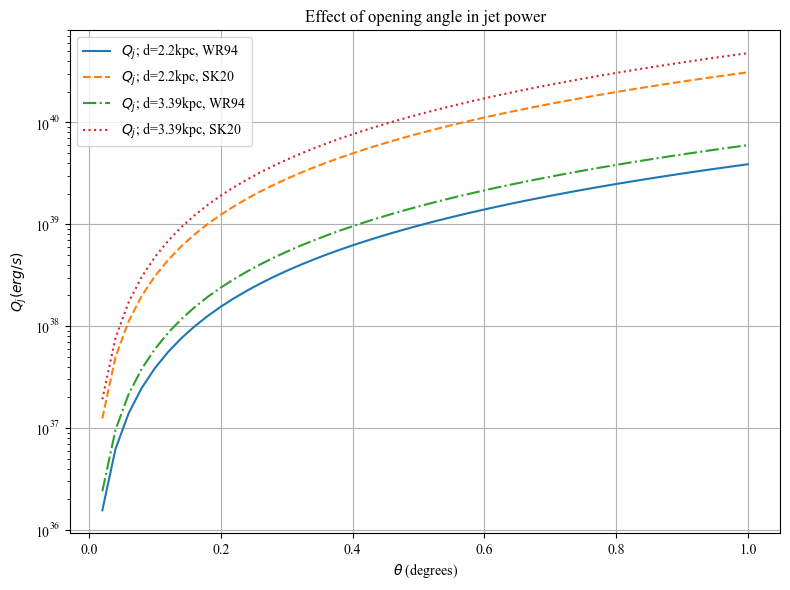

In [16]:
#Computing the C factors:

import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Times New Roman'
# Parameters
G_c = 5.0 / 3.0
G_j = 5.0 / 3.0
G_x = 5.0 / 3.0
beta = 0.
v = 4.0 * (10**5)  # km/s

# Range of theta values (converted to radians)
theta_values = np.linspace(0.02, 1.0, 50) * (np.pi / 180.0)

# Compute C_1 for each theta
C_1_values = []
Q_j_close_1_values = []
Q_j_close_2_values = []
Q_j_far_1_values = []
Q_j_far_2_values = []

for theta in theta_values:
    C_2 = (((G_c - 1.0) * (G_j - 1.0)) / (4 * G_c) + 1.0) ** (G_c / (G_c - 1.0)) * ((G_j + 1.0) / (G_j - 1.0))
    R_ax = np.sqrt(0.25 * C_2 / (theta**2))
    C_3 = np.pi / (4.0 * R_ax**2)
    
    C_1 = ((C_2 / (C_3 * theta**2)) * (((G_x + 1.0) * (G_c - 1.0) * (5.0 - beta)**3) / 
            (18.0 * (9.0 * (G_c + (G_c - 1.0) * (C_2 / (4.0 * theta**2))) - 4.0 - beta)))) ** (1.0 / (5.0 - beta))
    
    C_1_values.append(C_1)
    # Compute Q_j values
    Q_j_close_1 = (5.0 / 3.0) ** 3 * (rho_1_close / (C_1**5)) * (L_j_close**2) * v**3
    Q_j_close_2 = (5.0 / 3.0) ** 3 * (rho_2_close / (C_1**5)) * (L_j_close**2) * v**3
    Q_j_far_1 = (5.0 / 3.0) ** 3 * (rho_1_far / (C_1**5)) * (L_j_far**2) * v**3
    Q_j_far_2 = (5.0 / 3.0) ** 3 * (rho_2_far / (C_1**5)) * (L_j_far**2) * v**3

    Q_j_close_1_values.append(Q_j_close_1)
    Q_j_close_2_values.append(Q_j_close_2)
    Q_j_far_1_values.append(Q_j_far_1)
    Q_j_far_2_values.append(Q_j_far_2)

# Plot the results
plt.figure(figsize=(8, 6))
plt.plot(theta_values * (180.0 / np.pi), Q_j_close_1_values, label=r'$Q_j$; d=2.2kpc, WR94', linestyle='-')
plt.plot(theta_values * (180.0 / np.pi), Q_j_close_2_values, label=r'$Q_j$; d=2.2kpc, SK20', linestyle='--')
plt.plot(theta_values * (180.0 / np.pi), Q_j_far_1_values, label=r'$Q_j$; d=3.39kpc, WR94', linestyle='-.')
plt.plot(theta_values * (180.0 / np.pi), Q_j_far_2_values, label=r'$Q_j$; d=3.39kpc, SK20', linestyle=':')

plt.xlabel(r'$\theta$ (degrees)')
plt.ylabel(r'$Q_j (erg/s)$')
plt.title(r'Effect of opening angle in jet power')
plt.legend()
plt.grid(True)
plt.yscale('log')  # Optional: log scale if values vary significantly
plt.tight_layout()
plt.savefig("jet_power_openingangle.pdf", format="pdf", bbox_inches="tight")
plt.show()

## Impact of filling factor in Jet Power measurements:

When computing density we have assumed a parameter $f$ to account for the volume fraction filled by the emission area. The uncertainty on f is remarkably large and it has a big effect on the final calculation of $Q_j$. In this section we will sample a series of values of $f$ spanning from 0.005 to 0.48 and see its effect on $Q_j$. We insist on the fact that it's highly likely that the upper real limit is 0.1, but we are just trying to assess the effect of the filling factor in the jet power.

We will keep the volume and mass values obtained before.

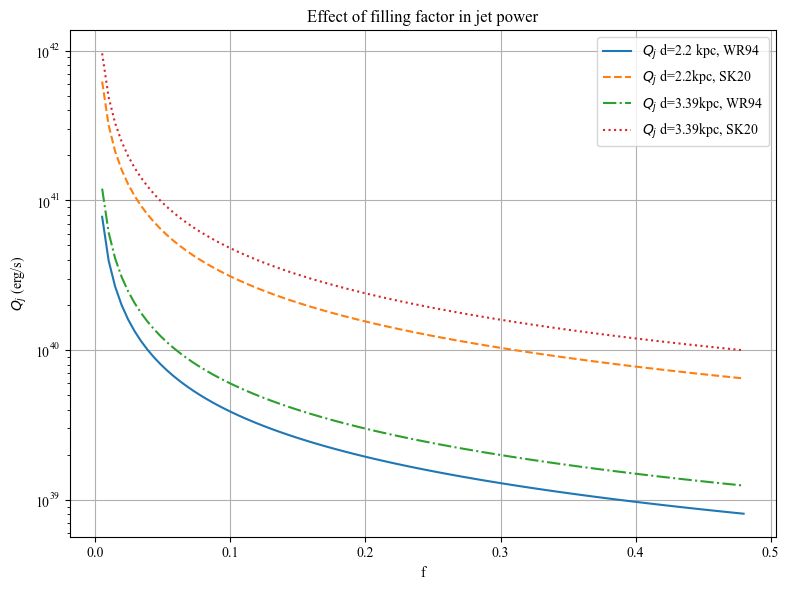

In [18]:
import numpy as np 
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Times New Roman'
#Computing the C factors in case we want to see the effect of f for different theta values:

#Parameters:
G_c=5./3.
G_j=5./3.
G_x=5./3.
theta= 1.0*(np.pi/180.0)
beta=0.0

#Computed values:
C_2=(((G_c-1.0)*(G_j-1.0))/(4*G_c) + 1.0)**(G_c/(G_c-1.0)) * ((G_j+1.0)/(G_j-1.0))
R_ax=np.sqrt(0.25*C_2/(theta**2))
C_3=np.pi/(4.0*R_ax**2)

C_1 = ((C_2/(C_3*theta**2))*(((G_x+1.0)*(G_c-1.0)*(5.0-beta)**3)/(18.0*(9.0*(G_c+(G_c-1.0)*(C_2/(4.0*theta**2)))-4.0-beta))))**(1.0/(5.0-beta))

#Now we compute the average density of the region for the whole setup
#We need to account for all 6 mass setups computed:
f_values=np.linspace(0.005, 0.48, 100)

rho_1_close_values = []
rho_2_close_values = []
rho_1_far_values = []
rho_2_far_values = []

Q_j_close_1_values = []
Q_j_close_2_values = []
Q_j_far_1_values = []
Q_j_far_2_values = []

for f in f_values:

    #Compute rho values
    rho_1_close = M_tot_close_1*Msun/(f*tot_V_close) #Wilson Rood; Chauhan
    rho_2_close = M_tot_close_2*Msun/(f*tot_V_close) #Kohno Sofue no He; Chauhan
    
    rho_1_far = M_tot_far_1*Msun/(f*tot_V_far) #Wilson Rood; Lamer
    rho_2_far = M_tot_far_2*Msun/(f*tot_V_far) #Kohno Sofue no He; Lamer
    
    rho_1_close_values.append(rho_1_close)
    rho_2_close_values.append(rho_2_close)

    rho_1_far_values.append(rho_1_far)
    rho_2_far_values.append(rho_2_far)
    
    # Compute Q_j values
    Q_j_close_1 = (5.0 / 3.0) ** 3 * (rho_1_close / (C_1**5)) * (L_j_close**2) * v**3
    Q_j_close_2 = (5.0 / 3.0) ** 3 * (rho_2_close / (C_1**5)) * (L_j_close**2) * v**3
    Q_j_far_1 = (5.0 / 3.0) ** 3 * (rho_1_far / (C_1**5)) * (L_j_far**2) * v**3
    Q_j_far_2 = (5.0 / 3.0) ** 3 * (rho_2_far / (C_1**5)) * (L_j_far**2) * v**3

    Q_j_close_1_values.append(Q_j_close_1)
    Q_j_close_2_values.append(Q_j_close_2)
    Q_j_far_1_values.append(Q_j_far_1)
    Q_j_far_2_values.append(Q_j_far_2)

# Plot the results
plt.figure(figsize=(8, 6))
plt.plot(f_values, Q_j_close_1_values, label=r'$Q_j$ d=2.2 kpc, WR94', linestyle='-')
plt.plot(f_values, Q_j_close_2_values, label=r'$Q_j$ d=2.2kpc, SK20', linestyle='--')
plt.plot(f_values, Q_j_far_1_values, label=r'$Q_j$ d=3.39kpc, WR94', linestyle='-.')
plt.plot(f_values, Q_j_far_2_values, label=r'$Q_j$ d=3.39kpc, SK20', linestyle=':')

plt.xlabel('f')
plt.ylabel('$Q_j$ (erg/s)')
plt.title(r'Effect of filling factor in jet power')
plt.legend()
plt.grid(True)
plt.yscale('log')  # Optional: log scale if values vary significantly
plt.tight_layout()
plt.savefig("jet_power_fillingfactor.pdf", format="pdf", bbox_inches="tight")
plt.show()


## Assessing the joint effect in the $\theta-f$ phase space:

We also create heatmaps to evaluate the possible combinations of $f$ and $\theta$ that we could potentially find.

We notice, that distance to the source does not have a massive effect on jet power estimation, but rather the density value of the cloud which is mostly affected by our $[H_2/^{13}CO]$ ratio.

Another previous consideration is that opening angle plays a largely more important role than filling factor does, since it belongs to a fifth power term.

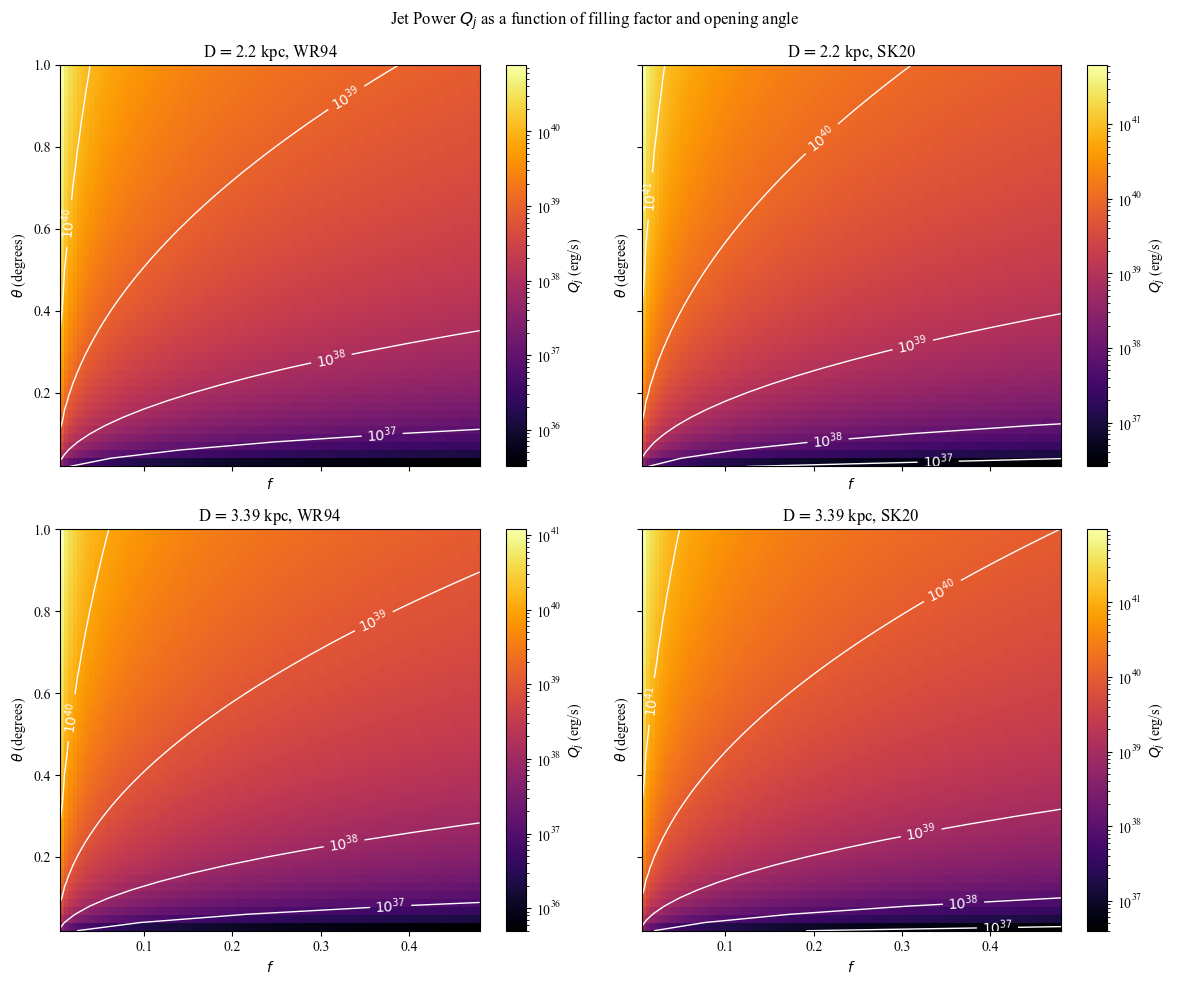

In [39]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Times New Roman'
# Parameters
G_c = 5.0 / 3.0
G_j = 5.0 / 3.0
G_x = 5.0 / 3.0
beta = 0.0
v = 4.0 * (10**5)  # km/s

# Range of f and theta values
f_values = np.linspace(0.005, 0.48, 100)
theta_values = np.linspace(0.02, 1.0, 50) * (np.pi / 180.0)

# Create 2D arrays for heatmap
Q_j_close_1_grid = np.zeros((len(f_values), len(theta_values)))
Q_j_close_2_grid = np.zeros((len(f_values), len(theta_values)))
Q_j_far_1_grid = np.zeros((len(f_values), len(theta_values)))
Q_j_far_2_grid = np.zeros((len(f_values), len(theta_values)))

# Compute Q_j for each combination of (f, theta)
for i, f in enumerate(f_values):
    for j, theta in enumerate(theta_values):
        # Compute C factors
        C_2 = (((G_c - 1.0) * (G_j - 1.0)) / (4 * G_c) + 1.0) ** (G_c / (G_c - 1.0)) * ((G_j + 1.0) / (G_j - 1.0))
        R_ax = np.sqrt(0.25 * C_2 / (theta**2))
        C_3 = np.pi / (4.0 * R_ax**2)

        C_1 = ((C_2 / (C_3 * theta**2)) * (((G_x + 1.0) * (G_c - 1.0) * (5.0 - beta)**3) /
                (18.0 * (9.0 * (G_c + (G_c - 1.0) * (C_2 / (4.0 * theta**2))) - 4.0 - beta)))) ** (1.0 / (5.0 - beta))

        # Compute densities
        rho_1_close = M_tot_close_1 * Msun / (f * tot_V_close)
        rho_2_close = M_tot_close_2 * Msun / (f * tot_V_close)
        rho_1_far = M_tot_far_1 * Msun / (f * tot_V_far)
        rho_2_far = M_tot_far_2 * Msun / (f * tot_V_far)

        # Compute Q_j values
        Q_j_close_1_grid[i, j] = (5.0 / 3.0) ** 3 * (rho_1_close / (C_1**5)) * (L_j_close**2) * v**3
        Q_j_close_2_grid[i, j] = (5.0 / 3.0) ** 3 * (rho_2_close / (C_1**5)) * (L_j_close**2) * v**3
        Q_j_far_1_grid[i, j] = (5.0 / 3.0) ** 3 * (rho_1_far / (C_1**5)) * (L_j_far**2) * v**3
        Q_j_far_2_grid[i, j] = (5.0 / 3.0) ** 3 * (rho_2_far / (C_1**5)) * (L_j_far**2) * v**3

# Create a figure with 4 subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 10), sharex=True, sharey=True)

# Titles and data for each subplot
titles = [r'D$=$2.2 kpc, WR94', r'D$=$2.2 kpc, SK20', 
          r'D$=$3.39 kpc, WR94', r'D$=$3.39 kpc, SK20']
data_grids = [Q_j_close_1_grid, Q_j_close_2_grid, Q_j_far_1_grid, Q_j_far_2_grid]

# Define contour levels
contour_levels = [1e37,1e38, 1e39, 1e40, 1e41, 1e42]

# Plot heatmaps
for ax, title, data in zip(axes.flat, titles, data_grids):
    im = ax.imshow(data.T, aspect='auto', origin='lower', 
                   extent=[f_values[0], f_values[-1], theta_values[0] * (180.0 / np.pi), theta_values[-1] * (180.0 / np.pi)],
                   cmap='inferno', norm=plt.matplotlib.colors.LogNorm())  # Log scale for better visualization
    # Add contour lines
    contours = ax.contour(f_values, theta_values * (180.0 / np.pi), data.T, levels=contour_levels, colors='white', linewidths=1)
    ax.clabel(contours, fmt={level: rf'$10^{{{int(np.log10(level))}}}$' for level in contour_levels}, colors='white', fontsize=10)
    
    ax.set_title(title)
    ax.set_xlabel(r'$f$')
    ax.set_ylabel(r'$\theta$ (degrees)')
    fig.colorbar(im, ax=ax, label=r'$Q_j$ (erg/s)')

plt.suptitle('Jet Power $Q_j$ as a function of filling factor and opening angle')
plt.tight_layout()
plt.savefig("jet_power_heatmaps.pdf", format="pdf", bbox_inches="tight")
plt.show()


## Physically motivated phase space exploration to constrain parameters:

As found in [Zdziarski et al., 2023](https://iopscience.iop.org/article/10.3847/2041-8213/accb5a/pdf) there is physical arguments that constrain the power available to the jet, for which we would find the maximal power to be constrained at:

$P_j = 1.3 h_{0.3} a_*^2 \dot{M}_{accr}c^2$,

Where we can constrain the $\dot{M}_{accr}c^2$ parameter with observations except for an efficiency factor that adjusts the power output. Namely, for our source:

$P_j \simeq 6.3h_{0.3}a_*^2\left(\frac{D}{2.2kpc}\right)^2\left(\frac{\epsilon}{0.05}\right)^{-1}10^{39}\frac{erg}{s}$,

Where:
- $h_{0.3}$ is a dimensional half thickness of the accretion disk $h=r\times0.3h_{0.3}$ with $h/r\simeq 0.3$ being approximately the maximum value this ratio can take for hot disks.
- $a_*$ is the dimensionless spin parameter, where 0 would describe a Schwarzschild BH and 1 would be for a maximally spinning Kerr BH. For BHXBs values typically lie between 0.1 and 0.93 .
- D is the distance to the source.
- $\epsilon$ is the radiative efficiency that is related to the spin and ranges from 0.057 for non-spinning BHs to 0.42 for maximally spinning BHs.


From this last formula, if we take $h_{0.3}$ to be 1 and we set the distance to both our estimates, we can explore the phase space defined by the values of $a^*$ and $\epsilon$ to get physical arguments on the source. Although, we notice that dimensionless spin parameter and radiative efficiency are not independent parameters and hence not all of the phase space points will have physical sense.

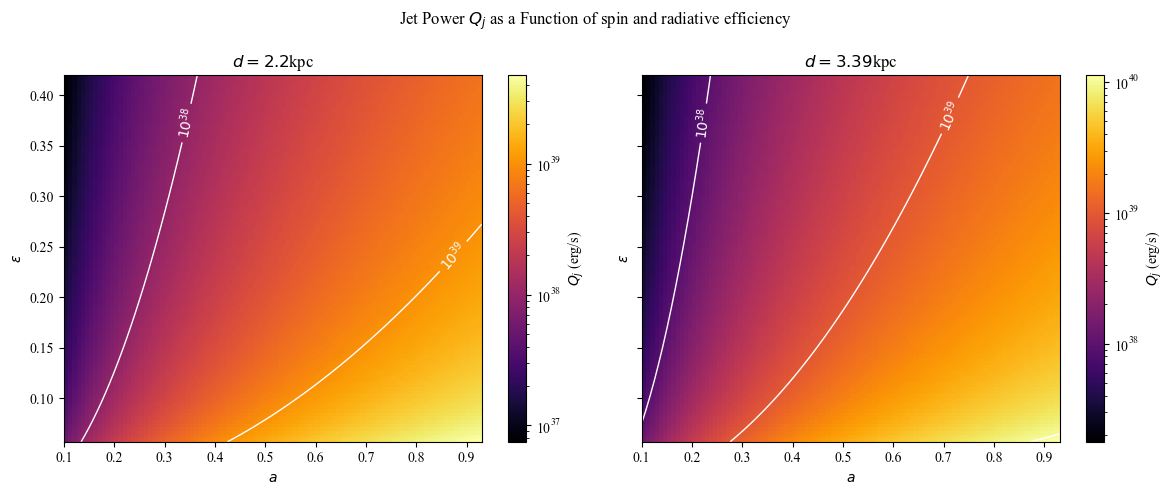

In [22]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Times New Roman'
# Parameters
D_1=2.2 #kpc
D_2=3.39 #kpc
# Range of f and theta values
a_values = np.linspace(0.1, 0.93, 100)
epsilon_values = np.linspace(0.057, 0.42, 100) 
# Create 2D arrays for heatmap
Q_j_close_grid = np.zeros((len(a_values), len(epsilon_values)))
Q_j_far_grid = np.zeros((len(a_values), len(epsilon_values)))

# Compute Q_j for each combination of (a, epsilon)
for i, a in enumerate(a_values):
    for j, epsilon in enumerate(epsilon_values):

        # Compute Q_j values
        Q_j_close_grid[i, j] = 6.3e39 * a**2 * (D_1/2.2)**2 * (epsilon/0.05)**(-1)
        Q_j_far_grid[i, j] = 6.3e39 * a**2 * (D_2/2.2)**2 * (epsilon/0.05)**(-1)

# Create a figure with 4 subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharex=True, sharey=True)

# Titles and data for each subplot
titles = [r'$d=2.2$kpc', r'$d=3.39$kpc', ]
data_grids = [Q_j_close_grid, Q_j_far_grid]

# Define contour levels
contour_levels = [1e38, 1e39, 1e40, 1e41, 1e42]

# Plot heatmaps
for ax, title, data in zip(axes.flat, titles, data_grids):
    im = ax.imshow(data.T, aspect='auto', origin='lower', 
                   extent=[a_values[0], a_values[-1], epsilon_values[0] , epsilon_values[-1]],
                   cmap='inferno', norm=plt.matplotlib.colors.LogNorm())  # Log scale for better visualization
    # Add contour lines
    contours = ax.contour(a_values, epsilon_values, data.T, levels=contour_levels, colors='white', linewidths=1)
    ax.clabel(contours, fmt={level: rf'$10^{{{int(np.log10(level))}}}$' for level in contour_levels}, colors='white', fontsize=10)
    
    ax.set_title(title)
    ax.set_xlabel(r'$a$')
    ax.set_ylabel(r'$\epsilon$')
    fig.colorbar(im, ax=ax, label=r'$Q_j$ (erg/s)')

plt.suptitle('Jet Power $Q_j$ as a Function of spin and radiative efficiency')
plt.tight_layout()
plt.savefig("jet_power_heatmaps_theo.pdf", format="pdf", bbox_inches="tight")
plt.show()


So, in order to make sense, our results would be physically explained by anything within the $10^{38}$ and $10^{39}$ range, which suggests opening angles well below 0.3 degrees for the close distance estimation and below 0.05 degrees for the far distance, and favoring the larger side of filling factors, even though they don't make as much physical sense. Also, we notice that the mass inferred with the [Wilson & Rood, 1994](https://adsabs.harvard.edu/full/1994ARA&A..32..191W) relation for our $[H_2/^{13}CO]$ ratio gives much more acceptable values than that derived by [Kohno & Sofue, 2023](https://www.ioa.s.u-tokyo.ac.jp/~sofue/news/2020_mn_Xco12co13_fugin.pdf). As for the distance estimation, [Chauhan et al., 2021](https://arxiv.org/pdf/2009.14419) seems to be more relaxed with constrains on the opening angle of the jet compared to [Lamer et al., 2021](https://www.aanda.org/articles/aa/pdf/2021/03/aa39757-20.pdf), although the difference is not extraordinary.